In [199]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split



data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')


class AccZDataset(Dataset):
    def __init__(self,start_no,range_len):
        data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
        self.start_no = start_no
        self.range_len = range_len
        self.data_set = data['L23MatChunk']
        self.n_trails = len(self.data_set)
        self.train_set = np.zeros((1,50000))
        
        for i in range (0,self.n_trails):
            curr = np.asarray(self.data_set[i][0][0][self.start_no : self.start_no+self.range_len]).reshape(1,self.range_len)
            self.train_set = np.append(self.train_set, curr, axis = 0)

        self.train_set = np.delete(self.train_set, (0), axis=0) #array of 20 * 50000
        
        labels = []
        for i in range(0, self.n_trails):
            if(i < 10):
                labels.append(0)
            else:
                labels.append(1)
        
        labels = np.asarray(labels).reshape(self.n_trails,1)
        self.train_set = np.append(self.train_set, labels, axis = 1)
        print(self.train_set.shape)
    def __len__(self):
        return len(self.train_set)

    def __getitem__(self, idx):
        
        sample = self.train_set[idx][:-1]
        label = self.train_set[idx][-1]

        return sample, label 



dataset = AccZDataset(20,50000)
real_value, real_label = dataset[13]
print(real_value)
print(real_value.shape)
print(real_label)




(20, 50001)
[0.04913539 0.0478669  0.05771144 ... 0.16863332 0.05331072 0.04423187]
(50000,)
1.0


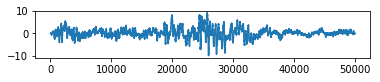

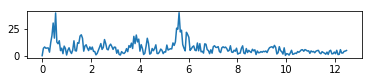

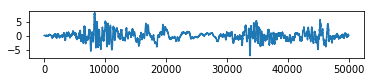

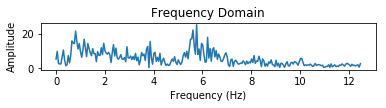

In [198]:
from scipy.fftpack import fft

real_value_lane2, real_label_lane2 = dataset[8]
real_value_lane3 , real_label_lane3 = dataset[13]

plt.subplot(4,1,1)
plt.plot(real_value_lane2)
plt.show()
sampling_rate = 50
N =1000
# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
yr = fft(real_value_lane2) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.subplot(4,1,2)
plt.plot(x[0:250], y[0:250])
plt.show()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain (Healthy Machinery)')


plt.subplot(4,1,3)
plt.plot(real_value_lane3)
plt.show()
sampling_rate = 50
N =1000
# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
yr = fft(real_value_lane3) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.subplot(4,1,4)
plt.plot(x[0:250], y[0:250])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain')
plt.show()

In [200]:
data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
start_no = 0
range_len = 50000
data_set = data['L23MatChunk']
total_set = np.zeros((1,50000))

for i in range (0,n_trails):

    curr = np.asarray(data_set[i][0][0][start_no : start_no+range_len]).reshape(1,range_len)
    total_set = np.append(total_set, curr, axis = 0)

total_set = np.delete(total_set, (0), axis=0) 

labels = []
for i in range(0, n_trails):
    if(i < 10):
        labels.append(0)
    else:
        labels.append(1)

labels = np.asarray(labels).reshape(n_trails,1)
total_set = np.append(total_set, labels, axis = 1)
targets_numpy = total_set[:,-1]
features_numpy = total_set[:,:-1]
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)



featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)

featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor)
targetsTest = torch.from_numpy(targets_test).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

batch_size = len(featuresTrain)
batch_size_test = len(featuresTest)
num_epochs = 30

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size_test, shuffle = False)

print(targets_train)


[0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.]


In [201]:

#Designing the model

filters = 1

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=25, stride=10))
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=5))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=3))
        self.avgLayer = nn.AvgPool1d(10, stride = 2)
        self.fc1 = nn.Linear(161, 1)
#        self.fc2 = nn.Linear(64,1)
        self.sig = nn.Sigmoid()
        


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
#         blah = out.detach()[0][10].view(1,1,-1)
#         out = self.avgLayer(blah)
#         plt.subplot(2,1,2)
#         plt.plot(out.detach().numpy()[0][0])
#         out = out.detach()[:][3].view(1,1,-1)
        out = self.avgLayer(out) # batch_size * features * out of avg layer (161)
        out = self.fc1(out)
#         out = self.fc2(out)
        out = self.sig(out)
        print(out.shape) #batch_size * filters * 1 (linear layer output dimension is 1)
        return out

    
model = ConvNet()
learning_rate = 0.001
# opt = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [177]:
# real_value, real_label = dataset[]

# plt.subplot(2,1,1)
# plt.plot()
# real_value = torch.from_numpy(real_value)
# real_value = real_value.view(1,1,50000)
# real_value = real_value.float()

print(featuresTrain.shape)
output = model(featuresTrain.view(16,1,-1))
print(output)



# m = nn.Softmax(dim = 1)
# # you softmax over the 2nd dimension
# input = torch.randn(1,2)
# output = m(input)
# print(input)
# print(output)

# loss = nn.CrossEntropyLoss()
# input = torch.tensor([[1,3]], dtype = torch.float)
# print(input.dtype)
# print(input.shape)
# target = torch.LongTensor([0])
# print(target)
# output = loss(input, target)
# print(output)
# # # output.backward()

# torch.max(2,1)






torch.Size([16, 50000])
torch.Size([16, 1, 1])
tensor([[[0.4889]],

        [[0.4816]],

        [[0.4825]],

        [[0.5006]],

        [[0.4848]],

        [[0.4762]],

        [[0.4862]],

        [[0.4615]],

        [[0.4777]],

        [[0.4691]],

        [[0.4919]],

        [[0.5060]],

        [[0.4644]],

        [[0.4646]],

        [[0.4799]],

        [[0.4780]]], grad_fn=<SigmoidBackward>)


torch.Size([16, 1, 1])
tensor([[[0.4940]],

        [[0.4974]],

        [[0.4997]],

        [[0.4975]],

        [[0.5040]],

        [[0.5026]],

        [[0.5004]],

        [[0.4968]],

        [[0.4957]],

        [[0.5051]],

        [[0.4937]],

        [[0.4956]],

        [[0.4986]],

        [[0.4999]],

        [[0.4993]],

        [[0.4998]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4940]],

        [[0.4974]],

        [[0.4997]],

        [[0.4975]],

        [[0.5040]],

        [[0.5026]],

        [[0.5004]],

        [[0.4968]],

        [[0.4957]],

        [[0.5052]],

        [[0.4937]],

        [[0.4956]],

        [[0.4986]],

        [[0.4999]],

        [[0.4993]],

        [[0.4998]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4940]],

        [[0.4974]],

        [[0.4997]],

        [[0.4975]],

        [[0.5041]],

        [[0.5026]],

        [[0.5004]],

        [[0.4967]],

        [[0.4957]],

        [[0.5052

/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


torch.Size([16, 1, 1])
tensor([[[0.4939]],

        [[0.4974]],

        [[0.4998]],

        [[0.4975]],

        [[0.5043]],

        [[0.5028]],

        [[0.5005]],

        [[0.4967]],

        [[0.4957]],

        [[0.5054]],

        [[0.4936]],

        [[0.4956]],

        [[0.4987]],

        [[0.5001]],

        [[0.4994]],

        [[0.4999]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4939]],

        [[0.4974]],

        [[0.4998]],

        [[0.4975]],

        [[0.5043]],

        [[0.5028]],

        [[0.5005]],

        [[0.4967]],

        [[0.4957]],

        [[0.5054]],

        [[0.4936]],

        [[0.4956]],

        [[0.4987]],

        [[0.5001]],

        [[0.4994]],

        [[0.4999]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4939]],

        [[0.4974]],

        [[0.4998]],

        [[0.4975]],

        [[0.5043]],

        [[0.5028]],

        [[0.5005]],

        [[0.4967]],

        [[0.4957]],

        [[0.5055

torch.Size([16, 1, 1])
tensor([[[0.4936]],

        [[0.4974]],

        [[0.4999]],

        [[0.4974]],

        [[0.5047]],

        [[0.5032]],

        [[0.5007]],

        [[0.4967]],

        [[0.4956]],

        [[0.5061]],

        [[0.4933]],

        [[0.4954]],

        [[0.4988]],

        [[0.5004]],

        [[0.4996]],

        [[0.5001]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4935]],

        [[0.4974]],

        [[0.5000]],

        [[0.4974]],

        [[0.5048]],

        [[0.5032]],

        [[0.5007]],

        [[0.4967]],

        [[0.4956]],

        [[0.5061]],

        [[0.4933]],

        [[0.4954]],

        [[0.4988]],

        [[0.5004]],

        [[0.4996]],

        [[0.5001]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4935]],

        [[0.4974]],

        [[0.5000]],

        [[0.4974]],

        [[0.5048]],

        [[0.5032]],

        [[0.5007]],

        [[0.4966]],

        [[0.4956]],

        [[0.5061

tensor([[[0.4932]],

        [[0.4974]],

        [[0.5001]],

        [[0.4973]],

        [[0.5052]],

        [[0.5035]],

        [[0.5008]],

        [[0.4966]],

        [[0.4955]],

        [[0.5066]],

        [[0.4930]],

        [[0.4952]],

        [[0.4989]],

        [[0.5007]],

        [[0.4997]],

        [[0.5002]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.4932]],

        [[0.4974]],

        [[0.5001]],

        [[0.4973]],

        [[0.5052]],

        [[0.5035]],

        [[0.5008]],

        [[0.4966]],

        [[0.4955]],

        [[0.5066]],

        [[0.4930]],

        [[0.4952]],

        [[0.4989]],

        [[0.5007]],

        [[0.4997]],

        [[0.5002]]], grad_fn=<SigmoidBackward>)
torch.Size([4, 1, 1])
Iteration: 80  Loss: 0.6881921887397766  Accuracy: 200 %
torch.Size([16, 1, 1])
tensor([[[0.4932]],

        [[0.4974]],

        [[0.5001]],

        [[0.4973]],

        [[0.5052]],

        [[0.5035]],

        [[0.5008]],

  

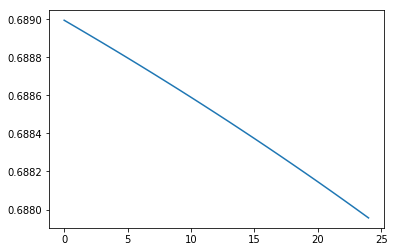

In [203]:
#  training model 
num_epochs = 100
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(train_loader):

        train = Variable(samples.view(batch_size,1,-1))
        labels = Variable(labels.view(batch_size,-1))
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        print(outputs)
        
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 4 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for samples, labels in test_loader:

                test = Variable(samples.view(batch_size_test,1,-1))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1].type(torch.FloatTensor)
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

plt.plot(loss_list)

17000
(50000,)
torch.Size([1, 2])
torch.float32
tensor([[0.1393, 0.0007]])
tensor([0])
tensor(0.6263)


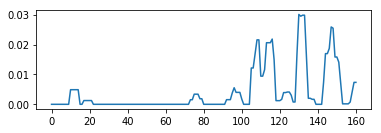

In [43]:
#Testing the model
model.eval()
real_value, real_label = trainSet(1)
real_value = torch.from_numpy(real_value)
real_value = real_value.view(1,1,50000)
real_value = Variable(real_value.float())
real_label = Variable(torch.LongTensor([0]))

with torch.no_grad():
    output = model(real_value)
print(output)
print(real_label)
loss = criterion(output, real_label)

# trial_no_2_test = np.random.randint(18,20)
# trial_no_1_test = np.random.randint(8,10)


# trial_no_test = np.random.randint(trial_no_1_test, trial_no_2_test)
# print(trial_no_test)

# real_value, real_label = trainSet(trial_no_test)

# real_value = torch.from_numpy(real_value)
# real_value = real_value.view(1,1,50000)
# real_value = real_value.float()

# output = model(real_value)
# nn.softmax(output)

# print(output)
print(loss)


In [11]:

trial_no_2 = random.randrange(11,18,1)
trial_no_1 = random.randrange(0,8,1)
print(trial_no_1)
print(trial_no_2)

trial_no_train = random.randint(trial_no_1, trial_no_2)
print(trial_no_train)

4
14
6
